## Como os deputados votam: Clusterização dos dados
### Um projeto de aprendizado não supervisionado

Quando o assunto é política, todo mundo tem um pitaco para dar: seja nos valores que a política deve ter; seja no que cada politico deveria fazer para melhorar nosso país; seja nos reajustes necessários na legislação brasileira. 

Mas, quando passamos a falar e politica na prática, considerando os projetos de lei, votações na câmara e decretos governamentais ninguém entende muito bem. Se tratando de um país do tamanho do Brasil é entendível que as regras de governo sejam complexas, cheias de processos e burocracias. É parte do sistema democrático.

Uma parte importante desse processo são as votações na câmara dos deputados. É la que são aprovados projetos, leis ementas e outras coisas do direito que mudam diretamente ou indiretamente nossa vida enquanto cidadãos. O interessante é que câmara legislativa disponibiliza um volume imenso de dados sobre o que acontece nessas votações, nos permitindo e incentivando a explorar esses dados.

Sabendo que a política é atualmente um assunto muito importante para nós brasileiros, mas que não entendemos muito bem o comportamento dos parlamentares nas votações e existem dados que nos permitem explorar um pouco esse comportamento, surgiu a ideia de desenvolver esse projeto: um estudo sobre os dados das votações na câmara dos deputados.

Essa é a terceira parte de três. Aqui eu irei clusterizar os dados da plataforma da câmara legislativa e explicar um pouco minhas escolhas e descobertas sobre o comportamento em votos dos parlamentares.

### Pré-processamentos

Nós começamos importando o dataset extraído na parte anterior e as bibliotecas essenciais para data science em python.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv('data/df.csv')

In [3]:
X=df.drop(['id', 'nome', 'siglaUf', 'siglaPartido', 'idLegislatura', 'cod_deputado'], axis=1)

for col in X.columns:
    X[col]=X[col].astype('float')

### Redução por principais componentes


Quando tratamos de bases de dados multi-dimensionais a representação gráfica desses dados é usualmente complexa. Se estamos falando de uma base de dados com centenas de colunas com dados semi-booleanos essa representação fica ainda mais complexa, pois não é viavel gerar centenas de gráficos correlacionando as votações, e não é possivel gerar um gráfico com centena de eixos.
 
 A solução escolhida nesse caso é fazer uma analise com base nos 2 principais componentes e em seguida plotar num gráfico simples destacando os maiores partidos. Essa analise nada mais é que DEFINIR TSNEEEEEE, e funciona muito bem com esse tipo de dados. Aqui eu usei a função da própria biblioteca do sklearn. Os eixos do gráfico são aleatorios e não representam nenhum parâmetro ideologico em especifico, sendo relevante nesse gráfico apenas as distâncias e agrupamentos dos pontos do gráfico.


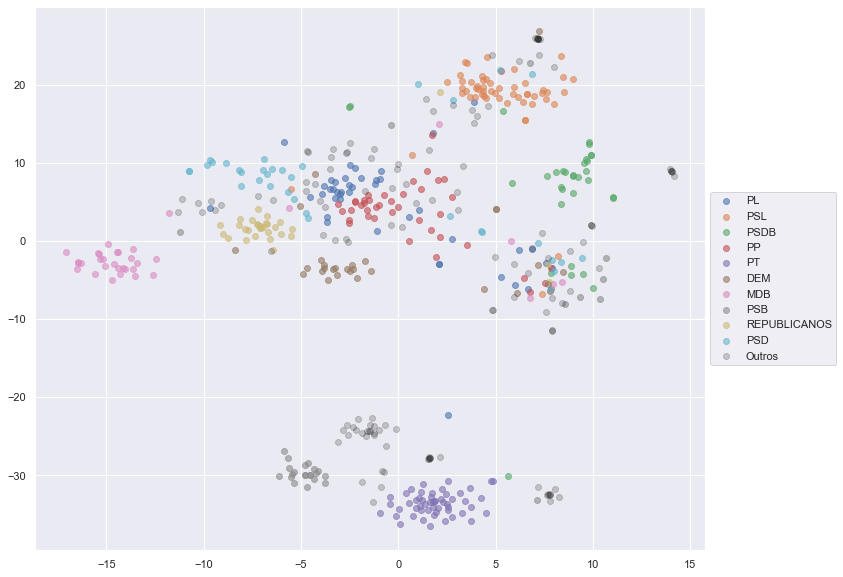

In [4]:
from sklearn.manifold import TSNE

model = TSNE(learning_rate=20)

tsne_features = model.fit_transform(X)

xs = tsne_features[:, 0]
ys = tsne_features[:, 1]

sns.set_theme()

fig = plt.figure(figsize=[15, 10])
ax = plt.subplot(111)

maiores_partidos=df.groupby('siglaPartido').id.count().sort_values(ascending=False)[0:10].index
for c in df.siglaPartido.unique():
    if c in maiores_partidos:
        x = xs[df.siglaPartido == c]
        y = ys[df.siglaPartido == c]
        plt.scatter(x, y, alpha=0.6, label=c)
    
x = xs[[a not in maiores_partidos for a in df.siglaPartido]]
y = ys[[a not in maiores_partidos for a in df.siglaPartido]]
plt.scatter(x, y, alpha=0.2, label='Outros', c='k')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Esse gráfico traz uma serie de insights interessantes sobre os deputados:

- Alguns partidos (em especial os que tem um posicionamento ideologico muito bem estabelecido como PT e PSL) tem o comportamento em votações tão consistente entre si que a propria máquina, com base apenas nos votos desses parlamentáres, os coloca em aglomerados muito evidentes no gráfico acima. 
- Os partidos do chamado centrão não tem um comportamento de votos muito conciso. No gráfico é visivel que existe um grande bloco envolvendo esses partidos (PSDB, PP, PL e Republicanos) mas que dentro desse bloco os votos divergem bastante.
- Os votos tem certa divisão entre esquerda-direita, embora não necessariamente linear, é visivel que alguns partidos auto-declarados de esquerda (como PT e PSB) estão em um lado do gráfico enquanto partidos auto-declarados de direita (como PSDB e PSL) se concentram do outro lado. 
- Existem de fato alguns deputados que se comportam como um "centro" politico, mas é um centro que evidentemente está inclinado a concordar mais com partidos de direita que com partidos de esquerda.

### Quantos tipos (clusters) de deputados tem?


O próximo passo no estudo desses dados é encontrar qual o numero ideal de divisões que podemos fazer nos dados. Para encontrar esse tipo de informação eu escolhi o método da sombracelha. O modelo de clusterização que eu vou usar é o kmeans, que leva em conta valores medios dos centros com base em um certo número de vizinhos. 

Sobre o método da sombracelha, a ideia é fazer a clusterização para diferentes números de clusters (grupos de deputados) e para cada grupo medir seu WSS (soma dos quadrados das distancias dentro do cluster) e avaliar o "ponto de sombracelha", que é o ponto de maior curvatura no gráfico numero_de_clusters x WSS.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


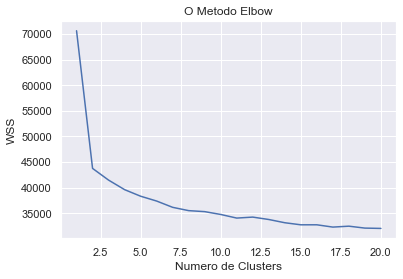

In [5]:
from sklearn.cluster import KMeans
wcss = []
 
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 21), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') 
#plt.grid() #within cluster sum of squares
plt.show()

Avaliando o ponto de sombracelha, temos que o número ideal de clusters é 2, podendo ser também de 3 a 5. 

### Alguns modelos de clusterização

Hora de testar os modelos de clusterização disponiveis no Sklearn. O código é mais ou menos o mesmo em cada modelo, mudando só a função do modelo. Eu decidi fazer o sistema com 3 clusters, dividindo assim os deputados entre esquerda, centro-direita e direita.

#### K-Means

In [6]:

print(sum(colors==2))

NameError: name 'colors' is not defined

#### Mistura Gaussiana

In [ ]:
from sklearn.mixture import GaussianMixture
n_clusters = 3
gmm_model = GaussianMixture(n_components=n_clusters)
gmm_model.fit(X)

colors = gmm_model.predict(X)
fig = plt.figure(figsize=[10, 10])
plt.scatter(xs, ys, c=colors, cmap='viridis', alpha=0.6)
plt.show()

#### Birch

In [ ]:
from sklearn.cluster import Birch

n_clusters = 3
birch = Birch(n_clusters=n_clusters)
birch.fit(X)

colors = birch.predict(X)
fig = plt.figure(figsize=[10, 10])
plt.scatter(xs, ys, c=colors, cmap='viridis', alpha=0.6)
plt.show()

#### Clusterização espectral

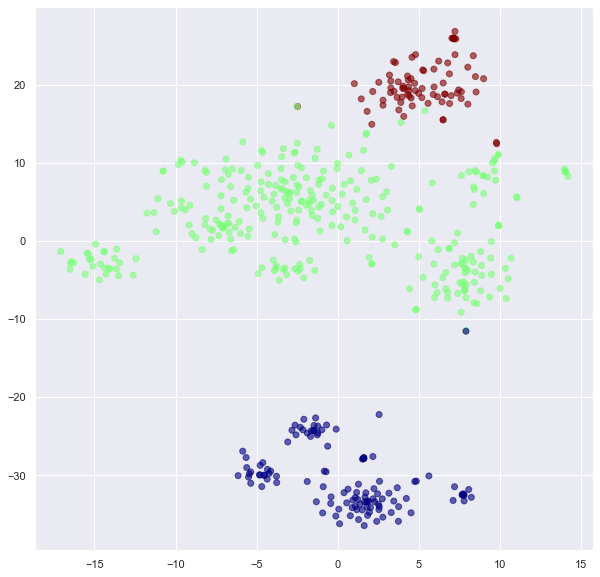

In [7]:
from sklearn.cluster import SpectralClustering

spectral_cluster_model= SpectralClustering(
    n_clusters=3, 
    random_state=42, 
    n_neighbors=15,
    affinity='nearest_neighbors',
    n_init=1250,
)
colors= spectral_cluster_model.fit_predict(X)
fig = plt.figure(figsize=[10, 10])
plt.scatter(xs, ys, c=colors, cmap='jet',  alpha=0.6)
plt.show()

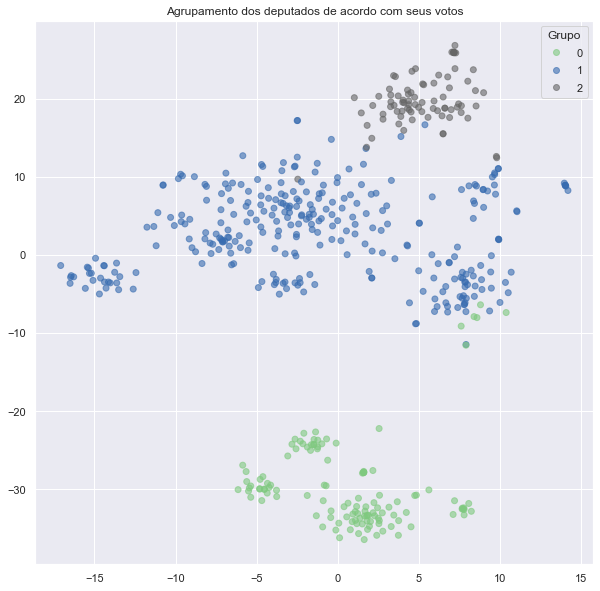

In [20]:
kmeans = KMeans(n_clusters = 3, init = 'random', n_init=1250, algorithm='elkan')
kmeans.fit(X)
colors = kmeans.labels_

fig = plt.figure(figsize=[10, 10])
scatter =plt.scatter(xs, ys, c=colors, cmap='Accent', alpha=0.6)
plt.title('Agrupamento dos deputados de acordo com seus votos')
plt.legend(*scatter.legend_elements(), title='Grupo')
plt.show()

Dos modelos testados, o método das médias K (KMeans) foi o que mais fez sentido vizualmente e com o agrupamento dos partidos e portanto será o modelo aplicado para a analise dos deputados nesse projeto. Os grupos serão salvos no proprio dataframe princial:

In [21]:
df['cluster']=colors
df.cluster=df.cluster.astype('category')

Um outro dado importante sobre esses clusters é a distância de cada ponto dos centros. Isso é uma forma de avalizar qualitativamente a qualidade dessa clusterização. Através dessa distância é possivel dizer, por exemplo, se um dado deputado está mais proximo da esquerda ou da direita, ou o quanto cada deputado está desse espectro político. Essas distâncias foram computadas no dataframe por meio desse código:

In [22]:
X['cluster']=colors
dists = X.drop('cluster', axis=1)- X[X.cluster==0].drop('cluster', axis=1).mean()
df['dist_0'] =np.sqrt(sum(dists[i]*dists[i] for i in dists))

dists = X.drop('cluster', axis=1)- X[X.cluster==1].drop('cluster', axis=1).mean()
df['dist_1'] =np.sqrt(sum(dists[i]*dists[i] for i in dists))

dists = X.drop('cluster', axis=1)- X[X.cluster==2].drop('cluster', axis=1).mean()
df['dist_2'] =np.sqrt(sum(dists[i]*dists[i] for i in dists))


### Os clusters

Os deputados foram dividios em 3 grupos: o grupo 0 (com 122 deputados), grupo 1 (com 320 deputados) e grupo 2 (com 71 deputados)

In [23]:
print('quantidades de deputados em cada',df.groupby('cluster').id.count())

quantidades de deputados em cada cluster
0    125
1    306
2     82
Name: id, dtype: int64


<AxesSubplot:ylabel='Count'>

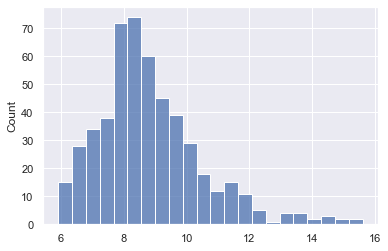

In [24]:
min_dist= df[['dist_0', 'dist_1', 'dist_2']].min(axis=1)
df['min_dist']= min_dist
sns.histplot(data=min_dist)

### Grupo 0

O primeiro grupo que eu decidi analisar foi o grupo 0. Esse grupo é preenchido pelos partidos de acordo com o seguinte gráfico:

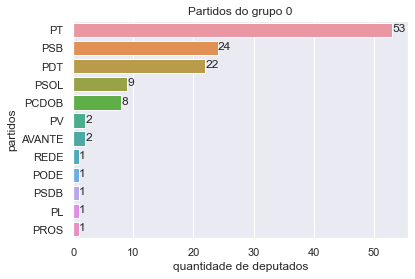

In [25]:
ax = sns.countplot(y='siglaPartido',
              data=df[df.cluster == 0],
              order=df[df.cluster == 0].siglaPartido.value_counts().index)
for p in ax.patches:
    ax.annotate('%.0f'%(p.get_width()), (p.get_x()+p.get_width(), p.get_y()+0.5))
plt.title('Partidos do grupo 0')
plt.xlabel('quantidade de deputados')
plt.ylabel('partidos')
plt.show()

Pelo gráfico acima é visivel que o grupo 0 representa os partidos de esquerda. O partido dominante na esquerda é o PT, com 53 deputados, seguido pelo PSB, com 24 deputados, e o PDT, com 22 deputados. Avaliando agora distância de cada deputado desse grupo (a esquerda) dos outros 2 grupos, chegamos nesse histograma aqui:

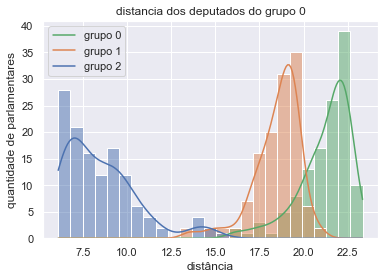

In [27]:
sns.histplot(data=df[df.cluster==0][['dist_0', 'dist_1', 'dist_2']], bins=25, kde=True)
plt.xlabel('distância')
plt.ylabel('quantidade de parlamentares')
plt.title('distancia dos deputados do grupo 0')
plt.legend(['grupo 0', 'grupo 1', 'grupo 2'])

Aqui vemos que a maioria dos deputados de esquerda, os grupos "centro" e "direita" estão bem mais distantes que o centro da esquerda. Nesse gráfico vemos também que a maioria dos deputados de esquerda tem uma distância entre 7 e 10 do centro desse grupo. Podemos avaliar também quais são os deputados, computados como esquerda, que estão mais distantes da esquerda:

In [503]:
df[df.cluster==0].drop([a for a in X.drop('cluster', axis=1)], axis=1).sort_values('dist_0').tail(10)

,id,nome,siglaUf,siglaPartido,idLegislatura,cod_deputado,dist_0,dist_1,dist_2,cluster,min_dist
86,204499,Cássio Andrade,PA,PSB,56,204499,11.409623,15.143589,17.729857,0,11.409623
90,204488,Célio Studart,CE,PV,56,204488,11.649098,18.462465,20.482747,0,11.649098
465,204360,Silvia Cristina,RO,PDT,56,204360,12.030773,17.160617,19.761388,0,12.030773
479,160976,Tiririca,SP,PL,56,160976,13.728492,15.662803,18.216523,0,13.728492
22,204544,Alexandre Frota,SP,PSDB,56,204544,13.841152,17.013447,18.754519,0,13.841152
444,204525,Rosana Valle,SP,PSB,56,204525,14.088488,16.277863,17.773823,0,14.088488
305,178931,Luciano Ducci,PR,PSB,56,178931,14.297115,14.673233,17.089799,0,14.297115
471,204534,Tabata Amaral,SP,PDT,56,204534,14.449481,17.765673,19.430150,0,14.449481
102,178939,Clarissa Garotinho,RJ,PROS,56,178939,14.472853,14.751920,17.148214,0,14.472853
38,204515,André Janones,MG,AVANTE,56,204515,15.151023,17.174894,18.610259,0,15.151023


Nessa lista temos alguns dos mais polêmicos deputados da câmara, entre eles Tabata Amaral, Alexandre Frota e Tirica. O que essa tabela traduz é que: entre os deputados computados como esquerda, os que se distânciam mais das tradicionais decisões médias da esquerda são esses representados acima. Esses deputados tem todos uma distância alta de todos os grupos, mas o mais proximo é o grupo 0.

### Grupo 1

Avaliando agora o grupo 1 pelo mesmo algoritmo de barras que o grupo anterior, temos que:

Text(0, 0.5, 'partidos')

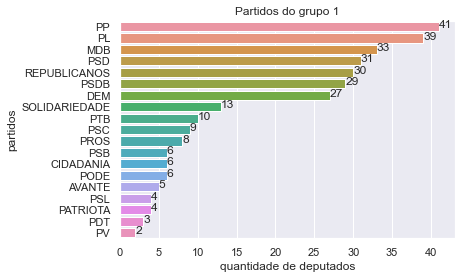

In [28]:
ax = sns.countplot(y='siglaPartido',
              data=df[df.cluster == 1],
              order=df[df.cluster == 1].siglaPartido.value_counts().index)
for p in ax.patches:
    ax.annotate('%.0f'%(p.get_width()), (p.get_x()+p.get_width(), p.get_y()+0.5))
plt.title('Partidos do grupo 1')
plt.xlabel('quantidade de deputados')
plt.ylabel('partidos')

Pela disposição acima é visivel que esse grupo trata-se dos deputados de centro-direita, o qual chamaremos apenas de centro aqui. É um grupo liderado pelo PP, PL, MDB, PSD, Republicanos, PSDB e DEM. Desses, o PP e o DEM são sucessores do partido da ditadura militar ARENA, enquanto o MDB é o outro sucessor do bipartidarismo da ditadura. Os partidos distribuem suas distâncias dos centros por meio do histograma:

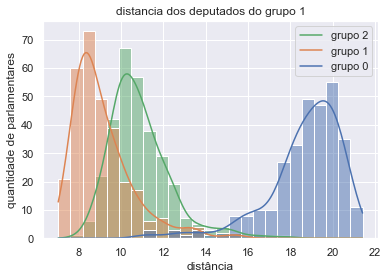

In [35]:
sns.histplot(data=df[df.cluster==1][['dist_0', 'dist_1', 'dist_2']], bins=25, kde=True)
plt.xlabel('distância')
plt.ylabel('quantidade de parlamentares')
plt.title('distancia dos deputados do grupo 1')
plt.legend(['grupo 2', 'grupo 1', 'grupo 0'])

Esse grupo está evidentemente mais próximo do grupo 2 que do grupo 0, o que demonstra sua proximidade com o grupo de direita que com o grupo de esquerda. Nesse grupo, os deputados tem em sua maioria de 6 a 10 de distância do centro do grupo. Avaliando os deputados mais ditantes têm-se que:

In [509]:
df[df.cluster==1].drop([a for a in X.drop('cluster', axis=1)], axis=1).sort_values('min_dist').tail(10)

,id,nome,siglaUf,siglaPartido,idLegislatura,cod_deputado,dist_0,dist_1,dist_2,cluster,min_dist
167,178953,Expedito Netto,RO,PSD,56,178953,17.256057,13.067442,15.001838,1,13.067442
298,204405,Liziane Bayer,RS,PSB,56,204405,16.991748,13.217630,14.841858,1,13.217630
114,178916,Daniel Coelho,PE,CIDADANIA,56,178916,18.275543,13.273451,13.774323,1,13.273451
394,141518,Paulo Pereira da Silva,SP,SOLIDARIEDADE,56,141518,13.771692,13.363686,15.700715,1,13.363686
287,178832,Leandre,PR,PV,56,178832,16.169523,13.461086,15.039591,1,13.461086
162,204537,Enrico Misasi,SP,PV,56,204537,17.667866,13.608131,14.554993,1,13.608131
173,160587,Fábio Trad,MS,PSD,56,160587,17.041288,13.701767,15.240959,1,13.701767
176,72442,Felipe Carreras,PE,PSB,56,72442,15.542892,14.775051,16.847784,1,14.775051
178,204371,Felipe Rigoni,ES,PSB,56,204371,17.213875,15.316642,16.271523,1,15.316642
503,160518,Weliton Prado,MG,PROS,56,160518,16.237102,15.600450,17.792853,1,15.600450


Não é surpreendente que os deputados mais distântes desse grupo são de partidos auto-considerados de esquerda ou centro esquerda, como é o caso do PV, do PSB e do Solidariedade. Dado que esse grupo é o mais amplo de todos, é esperado que ele englobe deputados da grande maioria dos partidos, incluindo partidos de esquerda e de estrema direita.

### Grupo 2

Por fim, eu analisei o grupo 2, através do mesmo gráfico de barras dos grupos anteriores.

Text(0, 0.5, 'partidos')

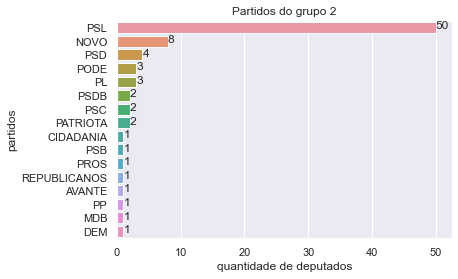

In [30]:
ax=sns.countplot(y='siglaPartido',
              data=df[df.cluster == 2],
              order=df[df.cluster == 2].siglaPartido.value_counts().index)
for p in ax.patches:
    ax.annotate('%.0f'%(p.get_width()), (p.get_x()+p.get_width(), p.get_y()+0.5))
plt.title('Partidos do grupo 2')
plt.xlabel('quantidade de deputados')
plt.ylabel('partidos')

Esse grupo (o qual chamarei de direita) é quase inteiramente composto pelo PSL. Todos os deputados do Novo (partido declaradamente de direita) também se encontram aqui. Avaliando as distâncias:

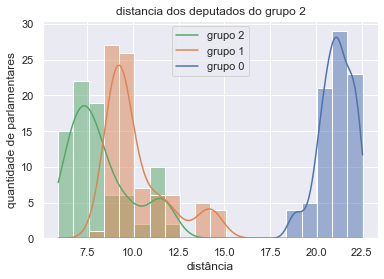

In [33]:
sns.histplot(data=df[df.cluster==2][['dist_0', 'dist_1', 'dist_2']], bins=20, kde=True)
plt.xlabel('distância')
plt.ylabel('quantidade de parlamentares')
plt.title('distancia dos deputados do grupo 2')
plt.legend(['grupo 2', 'grupo 1', 'grupo 0'])

Como o esperado os deputados desse grupo tem mais proximidade com os deputados do grupo 1 (composto por centro-direita). Os deputados aqui tem uma distancia entre 6 e 8 do centro do grupo. Sobre os deputados mais distantes do centro desse grupo temos que:

In [513]:
df[df.cluster==2].drop([a for a in X.drop('cluster', axis=1)], axis=1).sort_values('min_dist').tail(10)

,id,nome,siglaUf,siglaPartido,idLegislatura,cod_deputado,dist_0,dist_1,dist_2,cluster,min_dist
301,204523,Lucas Gonzalez,MG,NOVO,56,204523,22.250831,14.115126,11.439140,2,11.439140
497,204532,Vinicius Poit,SP,NOVO,56,204532,22.362904,14.231048,11.498951,2,11.498951
391,204461,Paulo Ganime,RJ,NOVO,56,204461,22.157290,14.156739,11.521995,2,11.521995
290,204359,Léo Moraes,RO,PODE,56,204359,20.023623,12.286804,11.567417,2,11.567417
204,204365,Gilson Marques,SC,NOVO,56,204365,22.356509,14.315533,11.586115,2,11.586115
25,204516,Alexis Fonteyne,SP,NOVO,56,204516,22.185164,14.279591,11.633122,2,11.633122
321,156190,Marcel van Hattem,RS,NOVO,56,156190,22.064394,14.203235,11.639148,2,11.639148
478,204519,Tiago Mitraud,MG,NOVO,56,204519,22.470503,14.345578,11.640196,2,11.640196
67,204502,Bozzella,SP,PSL,56,204502,19.175909,12.261110,11.898207,2,11.898207
282,204536,Kim Kataguiri,SP,DEM,56,204536,20.028617,13.561824,12.250446,2,12.250446


Os deputados mais distântes desse nucleo de direita são de maioria do partido Novo, o que indica certa diferenciação desse partido em relação os outros partidos de direita. Também é interessante notar um outro deputado muito falado nas midias digitais que é o Kim Kataguiri, sendo o deputado mais distante dos outros deputados de direita, estando também bem proximo da centro-direita.

### Considerações Finais

Os metodos de clusterização por aprendizado de maquina permitem concluir alguns aspectos sobre a organização dos partidos e deputados:

- Existe uma certa lacuna entre o que são os deputados de esquerda e o que são os deputados de centro e centro-direita. Isso pode indicar que o comportamento dos deputados de esquerda é razoavelmente caracteristico e definido, como também pode ser um indicativo da falta de deputados de centro-esquerda e de diversidade de opiniões nessa parte do espectro politico.
- Os partidos sucessores dos partidos da ditadura ainda são muito presentes na politica brasileira e ainda tem bastante força, compondo 20% dos parlamentares da camara dos deputados.
- O que se entende hoje como direita (ou extrema direita) é majoritariamente dominada pelo PSL e pelo partido Novo, dois partidos que ascenderam bastante nas eleições de 2018.
- Alguns deputados que não são bem aceitos na esquerda por não concordarem com algumas pautas de  (como Tabata Amaral e Tiririca) se comportam mais como esse espectro politico que como centro ou direita. Isso pode ser uma consequência do primeiro ponto, sendo os poucos deputados que se encontram nessa lacuna entre esquerda e centro.

In [92]:
quants={x[:7]:0 for x in X.columns}

for x in X.columns:
    quants[x[:7]]+=1
    
len(quants)

282

In [93]:
weights={x:0 for x in X.columns}
for a in quants:
    for b in weights:
        if a in b:
            weights[b]=1/quants[a]

In [94]:
for col in X.columns:
    X[col]=weights[col]*X[col]